# Example notebook: link graph

Install dependencies from the root folder of the repository into the currently active conda environment. 

In [1]:
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.window import Window
from research_common.spark import create_yarn_spark_session
import wikitextparser as wtp


In [ ]:
spark = create_yarn_spark_session(
    app_id='link_graph', 
    gitlab_project='repos/research/example-research-project'
)

## Work exclusively in notebook 

In [4]:
mw_snapshot = '2022-03'
wiki_db = 'simplewiki'
# wiki_db = 'enwiki'

wikitext_df = spark.read.format("avro").load(f"hdfs:///wmf/data/wmf/mediawiki/wikitext/history/snapshot={mw_snapshot}/wiki_db={wiki_db}")

In [5]:

# udf that returns the wikitext size in kilobytes
@F.udf(returnType='int')
def kb(wt):
    return len(wt.encode('utf-8'))//1024

# udf to extract the titles of the linked pages from a revision text
@F.udf(returnType='string')
def extract_links(wt):
    wl = wtp.parse(wt).wikilinks
    wiki_links = { l.title for l in wl }
    wiki_links_string = '#'.join(wiki_links)
    return wiki_links_string

wiki_links_df = (wikitext_df
  .where(F.col('page_namespace') == 0)
  .where(kb(F.col("revision_text")) < 1024) # smaller than 1mb, todo: looking at >1mb is a good chance at vandalism-  
  .withColumn("wiki_links", extract_links(F.col("revision_text")))
  .drop(F.col("revision_text")) 
) 


In [6]:

# udf to compare two sets of links
@F.udf(returnType='struct<added:array<string>,removed:array<string>>')
def added_removed_links(curr_links, prev_links):
    prev_links = set(prev_links.split('#'))
    curr_links = set(curr_links.split('#'))
    return Row(
        added=list(curr_links.difference(prev_links)),
        removed=list(prev_links.difference(curr_links))    
    )

rev_history = Window.partitionBy("page_id").orderBy("revision_id")
link_graph_df = (wiki_links_df
    .withColumn('added_removed_links', added_removed_links(
        F.col('wiki_links'),
        F.lag(F.col('wiki_links'), count=1, default="").over(rev_history)
    ))
)


In [7]:
link_graph_df.write.mode("overwrite").parquet(f"link_graph/{wiki_db}/delta") 

### Code in python package

The python package needs to be installed in the active conda environment, and `publish_conda_env` [gitlab CI pipeline](https://gitlab.wikimedia.org/repos/research/example-research-project/-/pipelines) needs to be run to generate a conda environment. 

In [ ]:
!cd .. && pip install . 

#### UDFs in the python package

The suffix "PP_" is to clearly mark which methods are in the python package, as the same methods also exist in the example notebook. I.e. they could have
same name, though to avoid confusion, in a real project a method should exist in either the notbook or the python package

In [63]:
from example_research.link_graph import (
    PP_kb,
    PP_extract_links, 
    PP_added_removed_links)


# use UDFs in notebook

#### Complete pipeline in python package

The spark pipeline itself can also be moved to the python package as a whole, e.g. to make a spark pipeline easily available to others.

In [61]:
from example_research.link_graph import extract_link_graph

extract_link_graph(spark, '2022-03', 'simplewiki')


DataFrame[wiki_db: string, page_id: bigint, page_namespace: int, page_title: string, page_redirect_title: string, page_restrictions: array<string>, user_id: bigint, user_text: string, revision_id: bigint, revision_parent_id: bigint, revision_timestamp: string, revision_minor_edit: boolean, revision_comment: string, revision_text_bytes: bigint, revision_text_sha1: string, revision_content_model: string, revision_content_format: string, wiki_links: string, added_removed_links: struct<added:array<string>,removed:array<string>>]

Implementing a pipeline as part of a python package makes it convenient to call from outside a juptyer notebook, e.g. from an airflow job. The command below is submitting the pipeline via spark-submit command line call.

In [ ]:

!spark2-submit \
    --master yarn \
    --packages org.apache.spark:spark-avro_2.11:2.4.4 \
    $(which link_graph.py) \
    --save_table fab.link_graph_simplewiki \
    --wiki_db simplewiki \
    --mediawiki_snapshot 2022-04      


### Link graph 'API'

/usr/lib/anaconda-wmf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


month            2013-03
pages              86481
links_added        66764
links_removed    2250696
Name: 138, dtype: object

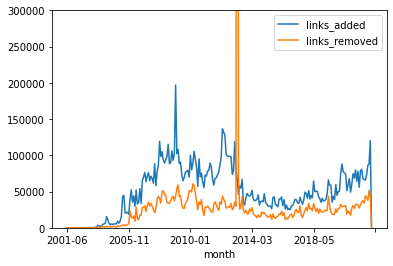

In [30]:
link_graph_df = spark.sql("select * from fab.link_graph_simplewiki").cache()

@F.udf(returnType='boolean')
def link_added_or_removed(delta):
    return len(delta.added)>0 or len(delta.removed)>0


stats = (link_graph_df
     .select('page_title', 'revision_timestamp', 'added_removed_links')
     .where(link_added_or_removed('added_removed_links'))
     .groupby(F.substring('revision_timestamp', 0, 7).alias('month'))
     .agg(
        F.countDistinct('page_title').alias('pages'),
        F.sum(F.size('added_removed_links.added')).alias('links_added'),
        F.sum(F.size('added_removed_links.removed')).alias('links_removed'),
     )
    .orderBy(F.col("month").asc())
).toPandas()

stats.plot('month', ['links_added', 'links_removed'],ylim=(0,3e5))
stats.loc[stats['links_removed'].idxmax()]



In [46]:
@F.udf(returnType='map<string,array<string>>')
def pages_by_month(months, pages):
    res = {}
    for m, p in zip(months, pages):
        if m not in res:
            res[m] = [p]
        else:
            res[m] = res[m] + [p]            
    return res

lookup = {}
for row in (link_graph_df
    .select(
         'page_title', 
         F.substring('revision_timestamp', 0, 7).alias('month'), 
         F.explode('added_removed_links.added').alias('added_link')
    )
    .groupby('added_link')
    .agg(
        F.collect_list('page_title').alias('pages'),
        F.collect_list('month').alias('months'),
    )
    .select(
        'added_link',
        pages_by_month('months', 'pages').alias('pages_by_month')
    )
    # .orderBy(F.col("month").asc())
).collect():
     lookup[row.added_link] = row.pages_by_month


In [102]:

def incoming_links(page, month=None):
    monthly = lookup.get(page)    
    if monthly:
        if month:
            return monthly.get(month)
        else:
            return sorted(monthly.items(), key=lambda kv: kv[0])
    else:
        return "nope"

    
# incoming_links("Soccer")
incoming_links("Switzerland", "2022-03")

['Yevhen Malyshev',
 '1960 Summer Olympics',
 'Pilatus PC-7',
 'Alice Moretti',
 'Whitney Dosty',
 'Toys "R" Us',
 'Chuck E. Cheese',
 '.swiss',
 'Samuel Schmid',
 '2022 Russian invasion of Ukraine',
 'France',
 'Mexican Air Force',
 'Moritz Leuenberger',
 'List of oldest living state leaders',
 'Louis Chevrolet',
 '1758']